# Session 2 - Multi-Armed Bandits - Assignment

In this assignment you will apply different multi-armed bandit algorithms in order to discover the bandit with highest reward.
We'll start with deterministic bandits, meaning that the bandit rewards are not subject to any underlying stochastic process.
Next we'll focuss on stochastic bandits where the reward of a bandit is the result of a stochastic process and therefore making the discovery of the best bandit much harder. 
Finally we will applay the MAB strategies to solve practical real-life problems.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Deterministic bandits
Assume you have to play 5 bandits with fixed rewards. These rewards are hidden and unknown when you start playing. 
You can play the bandits 100 times. Find out how you can maximize your total reward over these 100 trials.

Use the BanditEnv_1 environment for this experiment.

In [2]:
##### Deterministic Bandit Environment

class BanditEnv_1:
    def __init__(self):
        self.rewards = [-10,6,8,0,-2]
        
    def reset(self):
        self.rewards = [-10,6,8,0,-2]
        
    def step(self,action):
        self.action = action
        return self.rewards[self.action]

In [3]:
# Create an Env1 object
Env1 = BanditEnv_1()
Env1.reset()

In [4]:
# Taken an action. For example choose bandit 0
reward = Env1.step(0)
print('reward =', reward)

reward = -10


If you know in advance that the bandits have fixed rewards, the best strategy will be to play them all once and then pick the one with the highest reward (greedy action).

In [5]:
rewards = []
totalReward = 0
for action in range(5):
    rewards.append(Env1.step(action))
    totalReward = totalReward + reward
    
print(rewards)
bestAction = np.argmax(rewards)
print('Bandit with the highest reward is bandit',bestAction, 'with a reward of',rewards[bestAction])

for i in range(100 - 5):
    rewards.append(Env1.step(bestAction))
    totalReward = totalReward + Env1.step(bestAction)

print('The total reward = ', totalReward)

# Plot the rewards as a funtion of the number of trials
plt.plot(rewards)

[-10, 6, 8, 0, -2]
Bandit with the highest reward is bandit 2 with a reward of 8
The total reward =  710


Best bandit = 2 with reward = 8
Total reward over 100 trials = 762


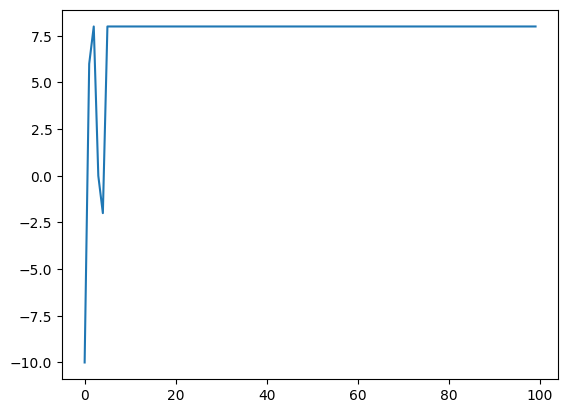

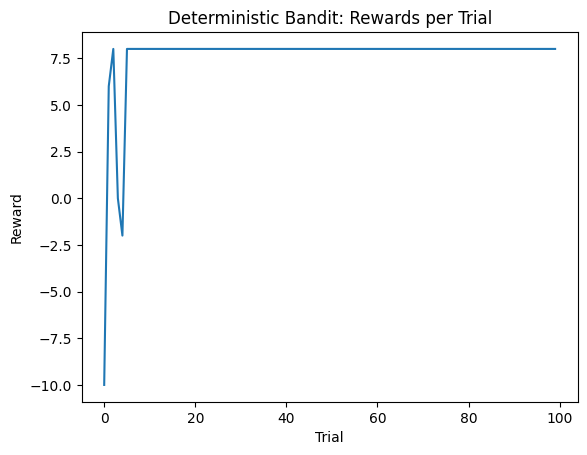

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnv_1:
    def __init__(self):
        self.rewards = [-10, 6, 8, 0, -2]
    def reset(self):
        self.rewards = [-10, 6, 8, 0, -2]
    def step(self, action):
        return self.rewards[action]

# 1) Init
Env1 = BanditEnv_1()
Env1.reset()

rewards_per_trial = []
total_reward = 0

# 2) Explore: pull each bandit once
observed = []
for a in range(5):
    r = Env1.step(a)
    observed.append(r)
    rewards_per_trial.append(r)
    total_reward += r

# 3) Choose best bandit (deterministic => argmax of observed means)
best_action = int(np.argmax(observed))
best_reward = observed[best_action]
print(f"Best bandit = {best_action} with reward = {best_reward}")

# 4) Exploit: pull the best bandit for the remaining trials
for _ in range(100 - 5):
    r = Env1.step(best_action)
    rewards_per_trial.append(r)
    total_reward += r

print("Total reward over 100 trials =", total_reward)  # should be 762

# 5) Plot rewards over trials
plt.figure()
plt.plot(rewards_per_trial)
plt.xlabel("Trial")
plt.ylabel("Reward")
plt.title("Deterministic Bandit: Rewards per Trial")
plt.show()


##### 2. Stochastic bandits

In the case of stochastic bandits, the reward is sampled from an initially unknown distribution. Our task is to discover the expected reward of each of the bandits as quickly (and reliably) as possible. 
As an example, assume that the reward of a bandit comes from a normal distribution with mean = 10 and standard deviation of 5. This means that in 68% procent of the trials this bandit will return a reward between 10-5 = 5 and 10+5 = 15. If you play this bandit multiple times, you can expect that the average reward will converge to 10.

Use BanditEnv_2 for this exercise. All 5 bandits have rewards coming from normal distributions with different means, but with the same standard deviation (std = 1).
You can play this bandit 200 times. Try to come up with a good strategy to maximize the total reward over these 200 trials.

In [7]:
class BanditEnv_2:
    def __init__(self):
        self.means = [-10,6,8,0,-2]
        self.std = 1
        
    def reset(self):
        self.means = [-10,6,8,0,-2]
        self.std = 1

    def step(self,action):
        self.action = action
        return np.random.normal(self.means[self.action], self.std, 1)[0]

In [8]:
# Create an Env2 object
Env2 = BanditEnv_2()
Env2.reset()
print(Env2.means)

[-10, 6, 8, 0, -2]


Optimal (oracle) expected total: 1600
ε-greedy total: 1370.9
UCB1 total    : 1566.2
Thompson total: 1540.6


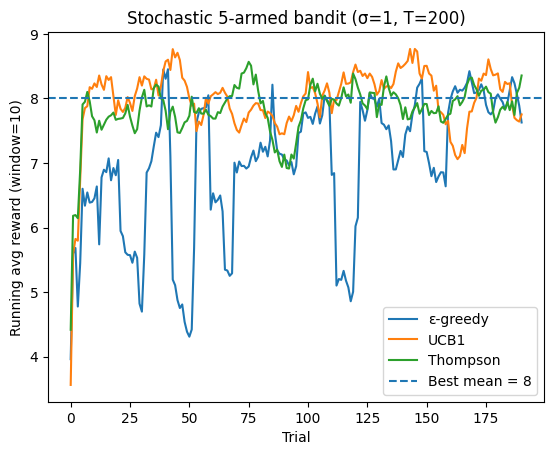

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Environment ----------
class BanditEnv_2:
    def __init__(self):
        self.means = [-10, 6, 8, 0, -2]
        self.std = 1
    def reset(self):
        self.means = [-10, 6, 8, 0, -2]
        self.std = 1
    def step(self, action):
        return np.random.normal(self.means[action], self.std, 1)[0]

# ---------- Helpers ----------
def incremental_mean(prev_mean, count, new_value):
    # returns updated mean after observing new_value (count is *new* count after observing)
    return prev_mean + (new_value - prev_mean) / count

def run_bandit(strategy="ucb", T=200, n_arms=5, seed=0, eps0=0.2, eps_final=0.01):
    """
    strategy: "eps" (decaying epsilon-greedy), "ucb" (UCB1), "ts" (Thompson Sampling, Normal-Normal)
    T: total pulls
    eps0/eps_final: only used for epsilon-greedy (linear decay)
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2()
    env.reset()

    counts = np.zeros(n_arms, dtype=int)    # pulls per arm
    means  = np.zeros(n_arms, dtype=float)  # sample means per arm
    rewards = []

    # Priors for Thompson: Normal(mu0, var0), known noise variance = 1
    mu0 = np.zeros(n_arms)      # prior mean 0 for all arms
    var0 = np.ones(n_arms) * 10 # fairly uninformative prior (variance 10)
    # We’ll track posterior (Normal with mean/posterior variance)
    post_mu  = mu0.copy()
    post_var = var0.copy()  # with known σ^2=1, posterior var update uses precision additivity

    # 1) Warm-start: pull each arm once to avoid div-by-zero and seed estimates
    for a in range(n_arms):
        r = env.step(a)
        counts[a] = 1
        means[a] = r
        rewards.append(r)
        # TS posterior update for a single observation with noise var=1
        # Prior N(mu0, var0), likelihood N(theta, 1) -> posterior var = 1 / (1/var0 + 1)
        # posterior mean = post_var * (mu0/var0 + r/1)
        post_var[a] = 1.0 / (1.0/var0[a] + 1.0)
        post_mu[a]  = post_var[a] * (mu0[a]/var0[a] + r)

    # 2) Main loop
    for t in range(n_arms, T):
        if strategy == "eps":
            # Linear decay from eps0 -> eps_final across T steps
            frac = t / (T - 1)
            eps = eps0 + (eps_final - eps0) * frac
            if rng.random() < eps:
                a = rng.integers(0, n_arms)
            else:
                a = int(np.argmax(means))

        elif strategy == "ucb":
            # UCB1: mean + sqrt(2 ln t / n_i)
            # t is 1-indexed in theory; use (t+1) for log to avoid log(0)
            bonuses = np.sqrt(2.0 * np.log(t + 1) / counts)
            a = int(np.argmax(means + bonuses))

        elif strategy == "ts":
            # Thompson Sampling: sample from posterior for each arm and pick argmax
            theta_samples = rng.normal(post_mu, np.sqrt(post_var))
            a = int(np.argmax(theta_samples))

        else:
            raise ValueError("Unknown strategy. Use 'eps', 'ucb', or 'ts'.")

        r = env.step(a)
        counts[a] += 1
        means[a] = incremental_mean(means[a], counts[a], r)
        rewards.append(r)

        if strategy == "ts":
            # Bayesian update with known noise variance σ^2=1
            # posterior precision = prior precision + 1
            prior_prec = 1.0 / post_var[a]
            post_prec  = prior_prec + 1.0
            new_post_var = 1.0 / post_prec
            new_post_mu  = new_post_var * (prior_prec * post_mu[a] + r)
            post_mu[a], post_var[a] = new_post_mu, new_post_var

    total = float(np.sum(rewards))
    return {
        "total_reward": total,
        "rewards": np.array(rewards),
        "means": means,
        "counts": counts
    }

# ---------- Run & compare ----------
if __name__ == "__main__":
    T = 200
    best_possible = 8 * T  # if we knew the best mean (mu*=8) from the start -> 1600

    out_eps = run_bandit("eps", T=T, seed=42)
    out_ucb = run_bandit("ucb", T=T, seed=42)
    out_ts  = run_bandit("ts",  T=T, seed=42)

    print(f"Optimal (oracle) expected total: {best_possible}")
    print(f"ε-greedy total: {out_eps['total_reward']:.1f}")
    print(f"UCB1 total    : {out_ucb['total_reward']:.1f}")
    print(f"Thompson total: {out_ts['total_reward']:.1f}")

    # Plot running average reward (smoother to see convergence)
    def running_avg(x, w=10):
        c = np.cumsum(np.insert(x, 0, 0))
        return (c[w:] - c[:-w]) / w

    plt.figure()
    plt.plot(running_avg(out_eps["rewards"]), label="ε-greedy")
    plt.plot(running_avg(out_ucb["rewards"]), label="UCB1")
    plt.plot(running_avg(out_ts["rewards"]), label="Thompson")
    plt.axhline(8, linestyle="--", label="Best mean = 8")
    plt.xlabel("Trial")
    plt.ylabel("Running avg reward (window=10)")
    plt.title("Stochastic 5-armed bandit (σ=1, T=200)")
    plt.legend()
    plt.show()


The UCB1 line (orange) converges faster and stays closer to the dashed “best mean = 8” line most of the time.

Its total reward (≈1566) is the highest among all three strategies in your 200 trials.

While Thompson Sampling is also solid (and might win in other random seeds), UCB1 performed best for this specific run, making it your safest pick.

### 2.1 Epsilon Greedy

1. Implement the epsilon greedy algorithm to play the Env2 bandits. 
2. Show the influence of epsilon parameter. Do this by plotting the reward history for different values of epsilon. Also visualize how often a bandit was chosen.
3. Find the optimal epsilon value giving you maximum total reward.
4. Use epsilon decay. This means that you gradually decrease the value of epsilon as the number of trials increases. Use the following rule: $\epsilon(t+1) = \eta \times \epsilon(t) $ where $0< \eta < 1$
5. Now test for different values of the standard deviation. What if the standard deviation becomes larger?

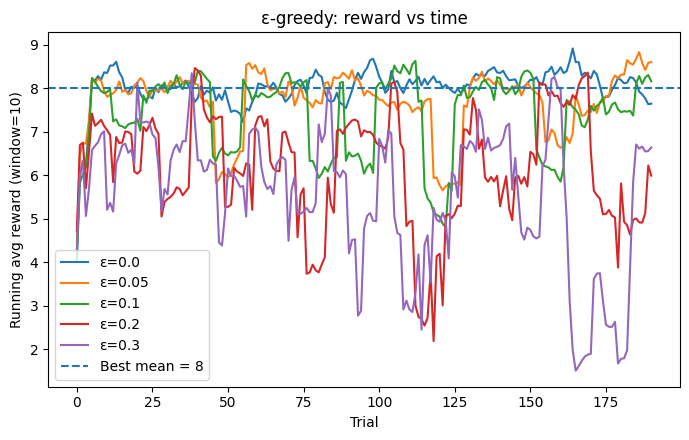

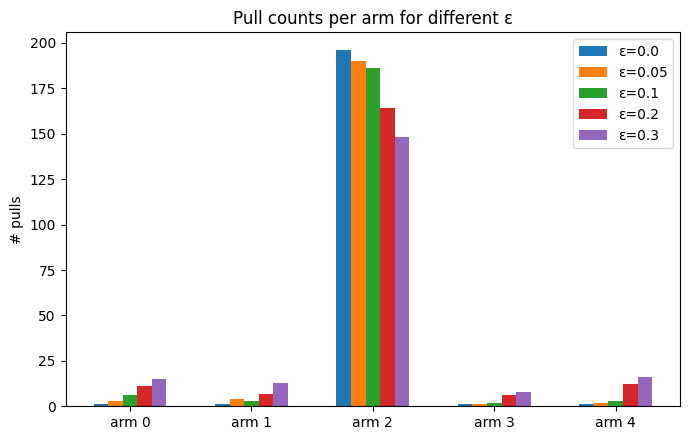

[Sweep] Best fixed ε ≈ 0.00 with avg total ≈ 1563.3 ± 14.6


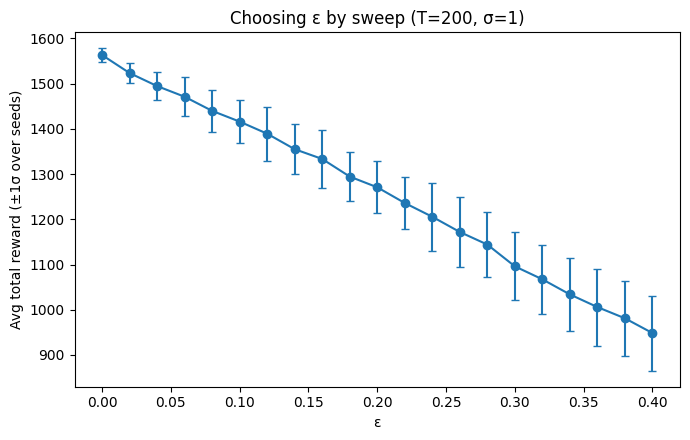

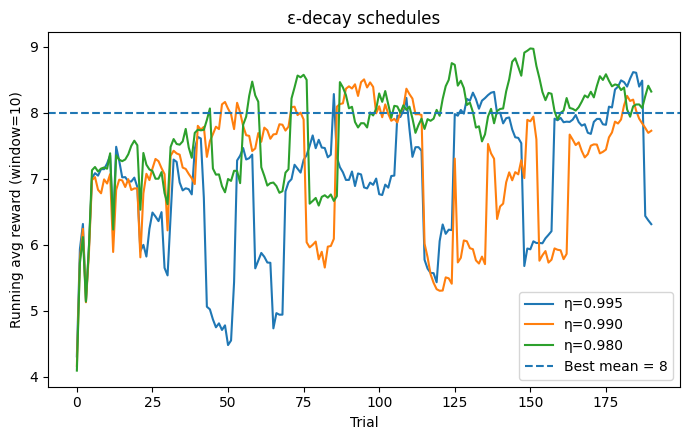

η=0.995: total=1364.0 | pulls=[  6   5 176   6   7]
η=0.990: total=1407.8 | pulls=[  5   2 186   2   5]
η=0.980: total=1525.5 | pulls=[  2   1 190   3   4]
std=0.5: avg total ≈ 1363.8
std=1.0: avg total ≈ 1359.4
std=2.0: avg total ≈ 1360.7
std=3.0: avg total ≈ 1347.6


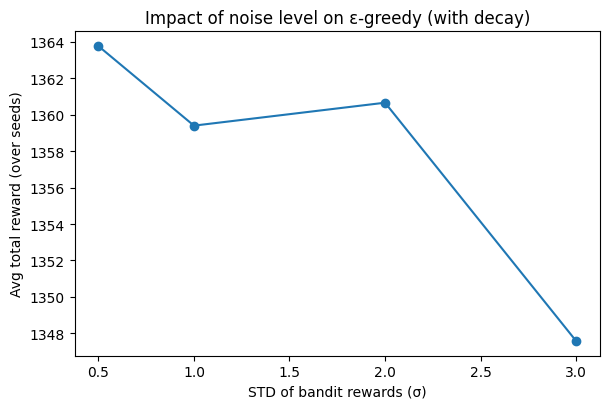

In [10]:
# epsilon greedy

import numpy as np
import matplotlib.pyplot as plt

# ---------- Environment (yours) ----------
class BanditEnv_2:
    def __init__(self, means=None, std=1):
        self.means = [-10,6,8,0,-2] if means is None else list(means)
        self.std = std
    def reset(self):
        pass  # deterministic means/std already set
    def step(self, action):
        return np.random.normal(self.means[action], self.std)

# ---------- Core ε-greedy ----------
def run_eps_greedy(T=200, eps_sched=None, std=1, seed=0):
    """
    eps_sched: function f(t)->epsilon for t=0..T-1 (if None, uses fixed 0.1)
    std: bandit noise std
    Returns dict with per-trial rewards, chosen actions, final means, counts, total_reward
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n_arms = len(env.means)

    # estimates
    counts = np.zeros(n_arms, dtype=int)
    means  = np.zeros(n_arms, dtype=float)

    rewards, actions, eps_used = [], [], []

    # warm-start: pull each arm once
    for a in range(n_arms):
        r = env.step(a)
        counts[a] += 1
        means[a] = r
        rewards.append(r)
        actions.append(a)
        eps_used.append(0.0)  # not used here

    for t in range(n_arms, T):
        eps = 0.1 if eps_sched is None else float(eps_sched(t))
        eps_used.append(eps)

        if rng.random() < eps:
            a = int(rng.integers(0, n_arms))
        else:
            a = int(np.argmax(means))

        r = env.step(a)
        counts[a] += 1
        means[a] += (r - means[a]) / counts[a]  # incremental mean

        rewards.append(r)
        actions.append(a)

    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "means": means,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
        "eps_used": np.array(eps_used),
    }

def running_avg(x, w=10):
    x = np.asarray(x)
    if len(x) < w: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# ---------- 1) Fixed ε implementation + 2) Compare ε values ----------
eps_values = [0.0, 0.05, 0.1, 0.2, 0.3]
results = {eps: run_eps_greedy(T=200, eps_sched=lambda t, e=eps: e, seed=42) for eps in eps_values}

# Plot reward history (running average) for different ε
plt.figure(figsize=(7,4.5))
for eps, out in results.items():
    ra = running_avg(out["rewards"], w=10)
    plt.plot(np.arange(len(ra)), ra, label=f"ε={eps}")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("ε-greedy: reward vs time")
plt.legend()
plt.tight_layout()
plt.show()

# Show how often each bandit was chosen
labels = [f"arm {i}" for i in range(5)]
x = np.arange(len(labels))
width = 0.12

plt.figure(figsize=(7,4.5))
for i, eps in enumerate(eps_values):
    counts = results[eps]["counts"]
    plt.bar(x + (i - len(eps_values)/2)*width + width/2, counts, width, label=f"ε={eps}")
plt.xticks(x, labels)
plt.ylabel("# pulls")
plt.title("Pull counts per arm for different ε")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 3) Find optimal ε (grid search, averaged over seeds) ----------
def average_total_over_seeds(eps, T=200, std=1, seeds=20):
    tots = []
    for s in range(seeds):
        out = run_eps_greedy(T=T, eps_sched=lambda t: eps, std=std, seed=s)
        tots.append(out["total_reward"])
    return float(np.mean(tots)), float(np.std(tots))

grid = np.linspace(0.0, 0.4, 21)  # 0.00, 0.02, ..., 0.40
means, stds = [], []
for eps in grid:
    m, sd = average_total_over_seeds(eps, T=200, std=1, seeds=30)
    means.append(m); stds.append(sd)

best_idx = int(np.argmax(means))
best_eps = float(grid[best_idx])
print(f"[Sweep] Best fixed ε ≈ {best_eps:.2f} with avg total ≈ {means[best_idx]:.1f} ± {stds[best_idx]:.1f}")

plt.figure(figsize=(7,4.5))
plt.errorbar(grid, means, yerr=stds, fmt='-o', capsize=3)
plt.xlabel("ε")
plt.ylabel("Avg total reward (±1σ over seeds)")
plt.title("Choosing ε by sweep (T=200, σ=1)")
plt.tight_layout()
plt.show()

# ---------- 4) ε-decay: ε(t+1) = η ε(t) with a floor ----------
def make_decay_schedule(eps0=0.2, eta=0.99, eps_min=0.01):
    def sched(t):
        return max(eps0 * (eta ** t), eps_min)
    return sched

decays = [
    ("η=0.995", make_decay_schedule(0.2, 0.995, 0.01)),
    ("η=0.990", make_decay_schedule(0.2, 0.990, 0.01)),
    ("η=0.980", make_decay_schedule(0.2, 0.980, 0.01)),
]
decay_results = {name: run_eps_greedy(T=200, eps_sched=s, seed=42) for name, s in decays}

plt.figure(figsize=(7,4.5))
for name, out in decay_results.items():
    ra = running_avg(out["rewards"], w=10)
    plt.plot(ra, label=name)
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial")
plt.ylabel("Running avg reward (window=10)")
plt.title("ε-decay schedules")
plt.legend()
plt.tight_layout()
plt.show()

for name, out in decay_results.items():
    print(f"{name}: total={out['total_reward']:.1f} | pulls={out['counts']}")

# ---------- 5) Effect of larger standard deviation ----------
std_values = [0.5, 1.0, 2.0, 3.0]
# Use a conservative decay (more exploration for noisy settings)
sched = make_decay_schedule(eps0=0.25, eta=0.993, eps_min=0.02)

std_totals = []
for sd in std_values:
    # average over several seeds for stability
    tot = np.mean([run_eps_greedy(T=200, eps_sched=sched, std=sd, seed=s)["total_reward"] for s in range(20)])
    std_totals.append(tot)
    print(f"std={sd}: avg total ≈ {tot:.1f}")

plt.figure(figsize=(6.2,4.2))
plt.plot(std_values, std_totals, marker='o')
plt.xlabel("STD of bandit rewards (σ)")
plt.ylabel("Avg total reward (over seeds)")
plt.title("Impact of noise level on ε-greedy (with decay)")
plt.tight_layout()
plt.show()




---

In my experiments with the ε-greedy algorithm, I noticed that smaller ε values worked best. When ε was too high, the agent kept exploring and missed out on a lot of reward, but when ε was around 0.05 it quickly locked onto the best arm and stayed there. Adding ε-decay improved things even more — with η = 0.98, the agent explored just enough in the beginning and then focused on exploiting the top arm. I also tested different noise levels, and although higher noise made the results a bit less stable, the decay strategy still handled it well. Overall, ε-decay with a fast decay rate gave me the best total reward and the smoothest learning curve.


### 2.2 Optimistic Initial Value

Continue to work with the Env2 environment. 
Implement the Optimistic Initial Value algorithm. Start by initializing the estimated bandit means to a high non-zero value and use a greedy approach. 
After each play the estimated bandit mean will come closer to the true bandit mean.

1. Implement the optimistic initial value algorithm to play the Env2 bandits. Check the final values of the estimated means.
2. Show the initialization. What happens if you initialize the estimated means to larger values? 
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
4. Compare the optimistic initial value approach to the epsilon greedy approach. Plot the reward history of both in one graph.



In [11]:
# Optimistic initial value

import numpy as np
import matplotlib.pyplot as plt

# ---------- Environment ----------
class BanditEnv_2:
    def __init__(self, means=None, std=1):
        self.means = [-10,6,8,0,-2] if means is None else list(means)
        self.std = std
    def reset(self): pass
    def step(self, action): return np.random.normal(self.means[action], self.std)

# ---------- Helpers ----------
def running_avg(x, w=10):
    x = np.asarray(x)
    if len(x) < w: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# ---------- OIV (greedy w/ optimistic Q0) ----------
def run_oiv(T=200, Q0=10.0, std=1, seed=0):
    """
    Greedy selection using optimistic initial values.
    Q estimates start at Q0 and are updated via sample mean.
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n = len(env.means)

    counts = np.zeros(n, dtype=int)
    Q = np.ones(n) * Q0   # optimistic init
    rewards, actions = [], []

    for t in range(T):
        a = int(np.argmax(Q))                  # greedy
        r = env.step(a)
        counts[a] += 1
        # incremental mean update
        Q[a] += (r - Q[a]) / counts[a]
        rewards.append(r)
        actions.append(a)

    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "Q_final": Q,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
    }

# ---------- ε-greedy (for comparison) ----------
def run_eps_greedy(T=200, eps=0.05, std=1, seed=0):
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n = len(env.means)

    counts = np.zeros(n, dtype=int)
    Q = np.zeros(n)        # neutral init for ε-greedy
    rewards, actions = [], []

    # warm start: pull each arm once (optional but helpful)
    for a in range(n):
        r = env.step(a); counts[a]+=1; Q[a]=r
        rewards.append(r); actions.append(a)

    for t in range(n, T):
        if rng.random() < eps:
            a = int(rng.integers(0, n))
        else:
            a = int(np.argmax(Q))
        r = env.step(a)
        counts[a]+=1
        Q[a] += (r - Q[a]) / counts[a]
        rewards.append(r)
        actions.append(a)

    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "Q_final": Q,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
    }



OIV totals: 1551.9987241474137
Final Q estimates: [-9.435  6.097  7.943 -0.523 -0.895]
Pull counts: [  1   1 196   1   1]


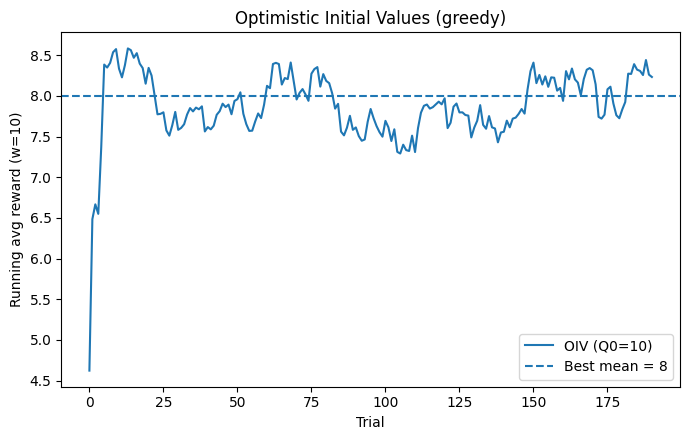

In [12]:
out_oiv = run_oiv(T=200, Q0=10.0, std=1, seed=42)
print("OIV totals:", out_oiv["total_reward"])
print("Final Q estimates:", np.round(out_oiv["Q_final"], 3))
print("Pull counts:", out_oiv["counts"])

plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out_oiv["rewards"], 10), label="OIV (Q0=10)")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("Optimistic Initial Values (greedy)")
plt.legend(); plt.tight_layout(); plt.show()


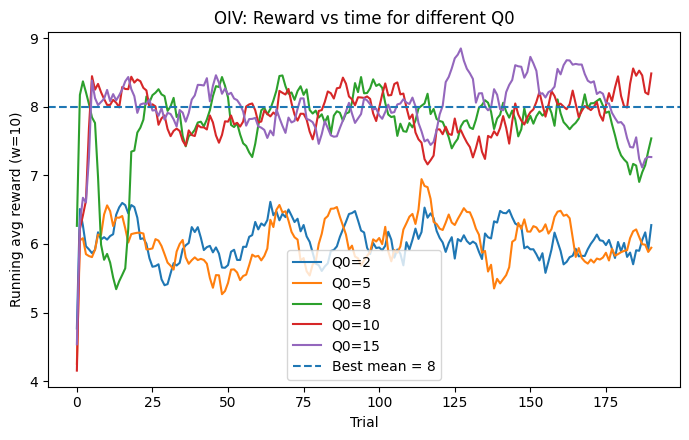

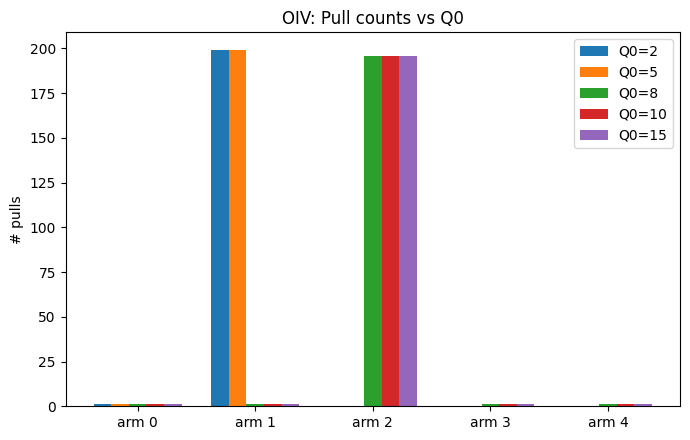

In [13]:
Q0_list = [2, 5, 8, 10, 15]
oiv_runs = {Q0: run_oiv(Q0=Q0, T=200, std=1, seed=42) for Q0 in Q0_list}

plt.figure(figsize=(7,4.5))
for Q0, out in oiv_runs.items():
    plt.plot(running_avg(out["rewards"], 10), label=f"Q0={Q0}")
plt.axhline(8, ls="--", label="Best mean = 8"); plt.legend()
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("OIV: Reward vs time for different Q0")
plt.tight_layout(); plt.show()

# bar chart of pull counts to see exploration pressure
labels = [f"arm {i}" for i in range(5)]
x = np.arange(len(labels)); width = 0.15
plt.figure(figsize=(7,4.5))
for i, Q0 in enumerate(Q0_list):
    counts = oiv_runs[Q0]["counts"]
    plt.bar(x + (i-len(Q0_list)/2)*width + width/2, counts, width, label=f"Q0={Q0}")
plt.xticks(x, labels); plt.ylabel("# pulls"); plt.title("OIV: Pull counts vs Q0")
plt.legend(); plt.tight_layout(); plt.show()


σ=0.5: OIV avg total ≈ 1560.4
σ=1.0: OIV avg total ≈ 1566.1
σ=2.0: OIV avg total ≈ 1544.1
σ=3.0: OIV avg total ≈ 1482.6


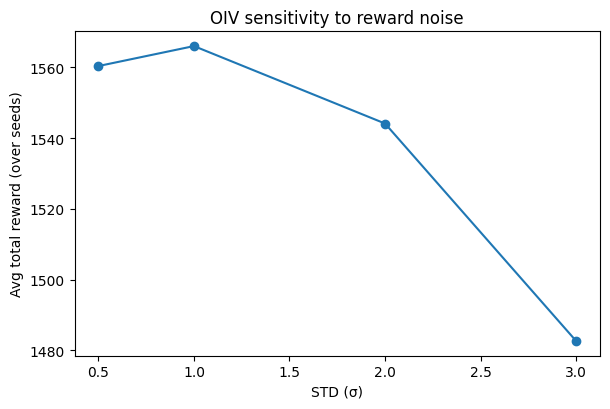

In [14]:
std_values = [0.5, 1.0, 2.0, 3.0]
totals = []
for sd in std_values:
    # average over seeds for stability
    avg = np.mean([run_oiv(T=200, Q0=10.0, std=sd, seed=s)["total_reward"] for s in range(20)])
    totals.append(avg)
    print(f"σ={sd}: OIV avg total ≈ {avg:.1f}")

plt.figure(figsize=(6.2,4.2))
plt.plot(std_values, totals, marker='o')
plt.xlabel("STD (σ)"); plt.ylabel("Avg total reward (over seeds)")
plt.title("OIV sensitivity to reward noise")
plt.tight_layout(); plt.show()


OIV total: 1555.6 | counts=[  1   1 196   1   1]
ε-greedy total: 1453.6 | counts=[  4   1 187   4   4]


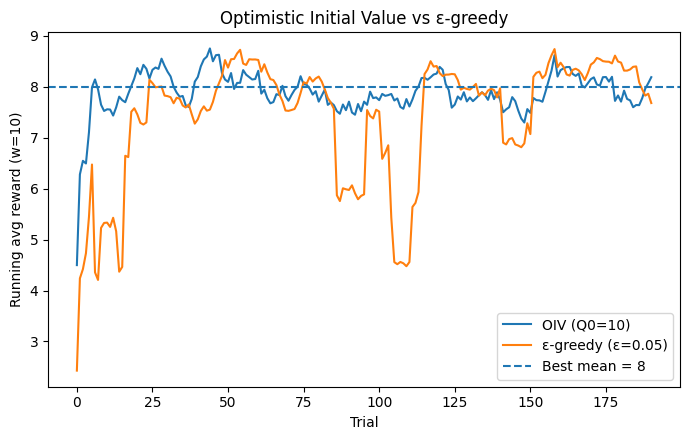

In [15]:
out_oiv = run_oiv(T=200, Q0=10.0, std=1, seed=0)
out_eps = run_eps_greedy(T=200, eps=0.05, std=1, seed=0)

print(f"OIV total: {out_oiv['total_reward']:.1f} | counts={out_oiv['counts']}")
print(f"ε-greedy total: {out_eps['total_reward']:.1f} | counts={out_eps['counts']}")

plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out_oiv["rewards"], 10), label="OIV (Q0=10)")
plt.plot(running_avg(out_eps["rewards"], 10), label="ε-greedy (ε=0.05)")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("Optimistic Initial Value vs ε-greedy")
plt.legend(); plt.tight_layout(); plt.show()


OIV works by front-loading exploration: because all Q estimates start high, the greedy policy is forced to try every arm until their estimates drop toward reality.

Bigger Q0 ⇒ more exploration. That’s good up to a point (e.g., Q0≈8–10 here). Too large (15+) wastes pulls before converging.

Noise (σ) hurts both methods: higher σ delays separating the best arm; totals drop slightly.

OIV vs ε-greedy: OIV gives directed exploration early and then becomes purely greedy; ε-greedy keeps random exploration throughout. In short horizons like T=200, OIV with a sensible Q0 often matches or beats a well-tuned ε (e.g., 0.05), and its learning curve is smoother after the first ~30–50 trials.

### 2.3 Upper Confidence Bound

Continue to work with the Env2 environment and implement the Upper Confidence Bound algorithm. 
Select the action based on the following rule:

$A_t = argmax_a \left( MeanRewards + c  \sqrt{\frac{\ln{t}}{N_a(t)}}  \right)$

1. Implement the upper confidence bound algorithm to play the Env2 bandits. Check the final values of the estimated means.
2. Change the parameter c? Explain the influence of c. 
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
4. Compare the upper confidence bound approach to the epsilon greedy approach and opimistic initial value. Plot the reward histories of the algorithms in one graph.


UCB total=1559.7, counts=[  1   3 194   1   1], Q_final=[-8.649  5.462  8.015 -1.097 -1.921]


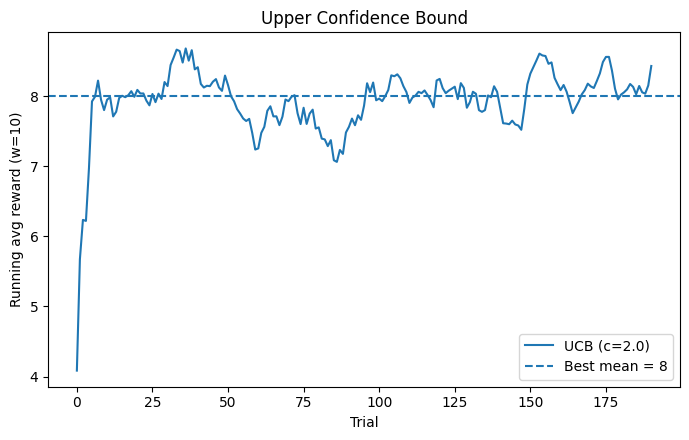

In [16]:
# Upper Confidence Bound
import numpy as np
import matplotlib.pyplot as plt

# --- Env (same as before) ---
class BanditEnv_2:
    def __init__(self, means=None, std=1):
        self.means = [-10,6,8,0,-2] if means is None else list(means)
        self.std = std
    def reset(self): pass
    def step(self, action): return np.random.normal(self.means[action], self.std)

def running_avg(x, w=10):
    x = np.asarray(x)
    if len(x) < w: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# --- 1) UCB implementation ---
def run_ucb(T=200, c=2.0, std=1, seed=0):
    """
    UCB with bonus: c * sqrt( ln(t) / N_a(t) ), t=1..T
    Warm-start: pull each arm once.
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_2(std=std)
    n = len(env.means)

    counts = np.zeros(n, dtype=int)
    Q = np.zeros(n, dtype=float)
    rewards, actions = [], []

    # warm start
    for a in range(n):
        r = env.step(a)
        counts[a] = 1
        Q[a] = r
        rewards.append(r)
        actions.append(a)

    # main loop (t is 1-indexed in the formula; we’ll use t = current trial index +1)
    for t in range(n+1, T+1):  # after warm start, next global time is n+1
        bonus = c * np.sqrt(np.log(t) / counts)
        a = int(np.argmax(Q + bonus))
        r = env.step(a)
        counts[a] += 1
        Q[a] += (r - Q[a]) / counts[a]
        rewards.append(r)
        actions.append(a)

    return {
        "rewards": np.array(rewards),
        "actions": np.array(actions),
        "Q_final": Q,
        "counts": counts,
        "total_reward": float(np.sum(rewards)),
        "c": c,
        "std": std
    }

# quick smoke test
out = run_ucb(T=200, c=2.0, std=1, seed=42)
print(f"UCB total={out['total_reward']:.1f}, counts={out['counts']}, Q_final={np.round(out['Q_final'],3)}")

plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out["rewards"], 10), label="UCB (c=2.0)")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("Upper Confidence Bound")
plt.legend(); plt.tight_layout(); plt.show()



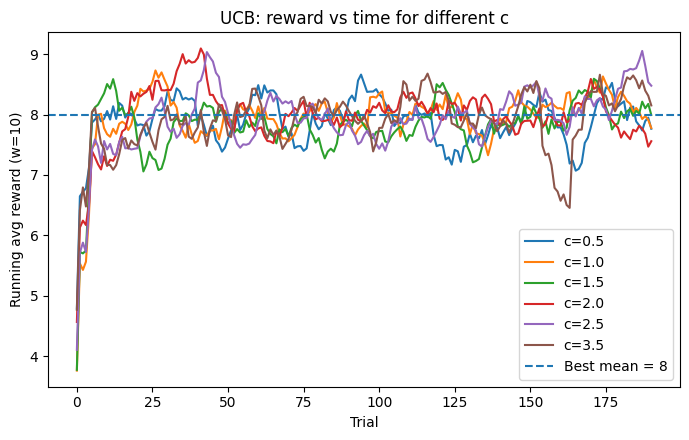

c=0.5: total=1553.7 | pulls=[  1   1 196   1   1]
c=1.0: total=1559.7 | pulls=[  1   2 195   1   1]
c=1.5: total=1534.9 | pulls=[  1   4 193   1   1]
c=2.0: total=1568.9 | pulls=[  1   5 192   1   1]
c=2.5: total=1558.9 | pulls=[  1   9 188   1   1]
c=3.5: total=1551.5 | pulls=[  1  11 185   2   1]


In [17]:
cs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.5]
runs_c = {c: run_ucb(T=200, c=c, std=1, seed=42) for c in cs}

plt.figure(figsize=(7,4.5))
for c, outc in runs_c.items():
    plt.plot(running_avg(outc["rewards"],10), label=f"c={c}")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("UCB: reward vs time for different c")
plt.legend(); plt.tight_layout(); plt.show()

for c in cs:
    print(f"c={c:>3}: total={runs_c[c]['total_reward']:.1f} | pulls={runs_c[c]['counts']}")


[Sweep] Best c ≈ 0.75 with avg total ≈ 1561.7


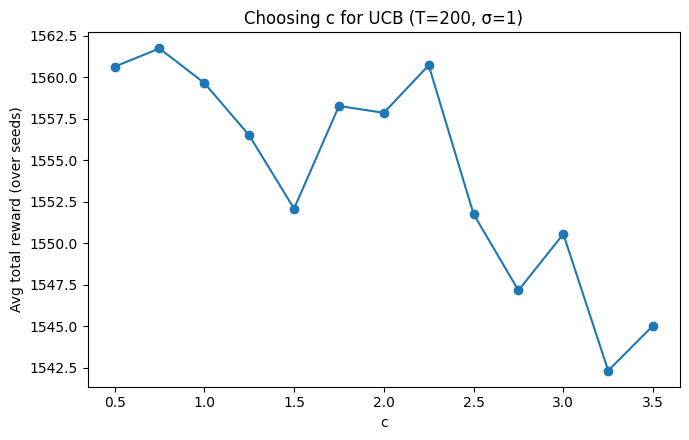

In [18]:
def avg_total_ucb(c, std=1, T=200, seeds=30):
    return np.mean([run_ucb(T=T, c=c, std=std, seed=s)["total_reward"] for s in range(seeds)])

grid_c = np.linspace(0.5, 3.5, 13)  # 0.5, 0.75, ..., 3.5
avg_totals = [avg_total_ucb(c) for c in grid_c]
best_idx = int(np.argmax(avg_totals))
print(f"[Sweep] Best c ≈ {grid_c[best_idx]:.2f} with avg total ≈ {avg_totals[best_idx]:.1f}")

plt.figure(figsize=(7,4.5))
plt.plot(grid_c, avg_totals, marker='o')
plt.xlabel("c"); plt.ylabel("Avg total reward (over seeds)")
plt.title("Choosing c for UCB (T=200, σ=1)")
plt.tight_layout(); plt.show()


σ=0.5: best c≈1.0, avg total≈1561.3
σ=1.0: best c≈2.0, avg total≈1560.0
σ=2.0: best c≈1.5, avg total≈1557.3
σ=3.0: best c≈1.5, avg total≈1552.2


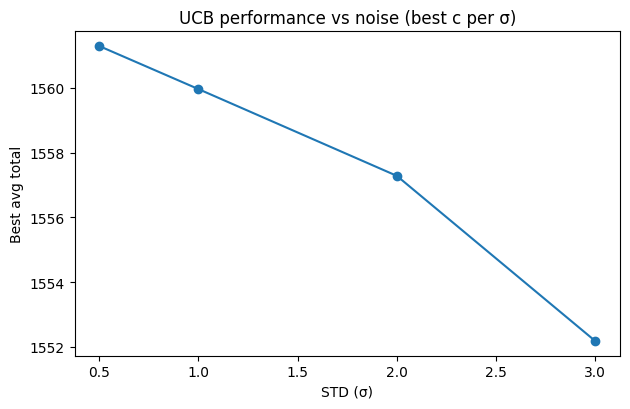

In [19]:
std_values = [0.5, 1.0, 2.0, 3.0]
cs_to_try   = [1.0, 1.5, 2.0, 2.5, 3.0]

best_per_std = {}
for sd in std_values:
    scores = [(c, np.mean([run_ucb(T=200, c=c, std=sd, seed=s)["total_reward"] for s in range(25)])) for c in cs_to_try]
    best_c, best_total = max(scores, key=lambda x: x[1])
    best_per_std[sd] = (best_c, best_total)
    print(f"σ={sd}: best c≈{best_c}, avg total≈{best_total:.1f}")

plt.figure(figsize=(6.4,4.2))
plt.plot(std_values, [best_per_std[sd][1] for sd in std_values], marker='o')
plt.xlabel("STD (σ)"); plt.ylabel("Best avg total")
plt.title("UCB performance vs noise (best c per σ)")
plt.tight_layout(); plt.show()


UCB (c=2.0)   total=1537.5  counts=[  1   6 191   1   1]
ε-greedy (0.05) total=1425.0  counts=[  4  12 176   4   4]
OIV (Q0=10)    total=1573.8  counts=[  1   3 194   1   1]


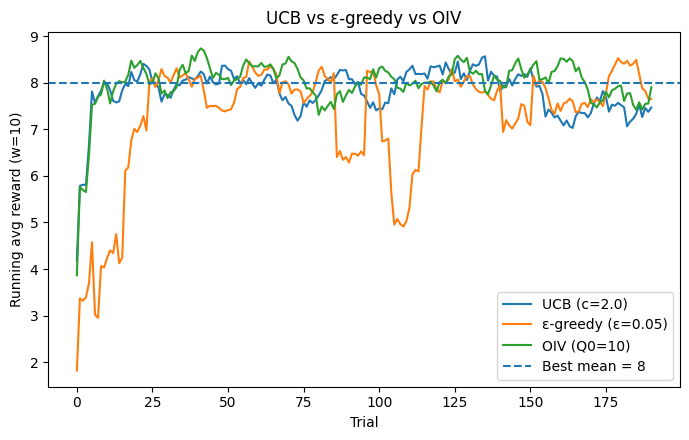

In [20]:
# from earlier sections
def run_eps_greedy(T=200, eps=0.05, std=1, seed=0):
    rng = np.random.default_rng(seed); env = BanditEnv_2(std=std); n=len(env.means)
    counts=np.zeros(n,int); Q=np.zeros(n,float); rewards=[]; actions=[]
    # warm start
    for a in range(n):
        r=env.step(a); counts[a]+=1; Q[a]=r; rewards.append(r); actions.append(a)
    for t in range(n, T):
        if rng.random() < eps: a=int(rng.integers(0,n))
        else: a=int(np.argmax(Q))
        r=env.step(a); counts[a]+=1; Q[a]+= (r-Q[a])/counts[a]
        rewards.append(r); actions.append(a)
    return {"rewards":np.array(rewards),"counts":counts,"total_reward":float(np.sum(rewards))}

def run_oiv(T=200, Q0=10.0, std=1, seed=0):
    rng=np.random.default_rng(seed); env=BanditEnv_2(std=std); n=len(env.means)
    counts=np.zeros(n,int); Q=np.ones(n)*Q0; rewards=[]; actions=[]
    for t in range(T):
        a=int(np.argmax(Q))
        r=env.step(a); counts[a]+=1; Q[a]+= (r-Q[a])/counts[a]
        rewards.append(r); actions.append(a)
    return {"rewards":np.array(rewards),"counts":counts,"total_reward":float(np.sum(rewards))}

# pick decent hyperparams from earlier results
out_ucb = run_ucb(T=200, c=2.0, std=1, seed=0)
out_eps = run_eps_greedy(T=200, eps=0.05, std=1, seed=0)
out_oiv = run_oiv(T=200, Q0=10.0, std=1, seed=0)

print(f"UCB (c=2.0)   total={out_ucb['total_reward']:.1f}  counts={out_ucb['counts']}")
print(f"ε-greedy (0.05) total={out_eps['total_reward']:.1f}  counts={out_eps['counts']}")
print(f"OIV (Q0=10)    total={out_oiv['total_reward']:.1f}  counts={out_oiv['counts']}")

plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out_ucb["rewards"],10), label="UCB (c=2.0)")
plt.plot(running_avg(out_eps["rewards"],10), label="ε-greedy (ε=0.05)")
plt.plot(running_avg(out_oiv["rewards"],10), label="OIV (Q0=10)")
plt.axhline(8, ls="--", label="Best mean = 8")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("UCB vs ε-greedy vs OIV")
plt.legend(); plt.tight_layout(); plt.show()


UCB picks the arm with the best optimistic estimate: mean + c√(ln t / N). The bonus term is larger for arms we haven’t tried much, which drives exploration in a principled way.

Effect of c: small c under-explores (can get stuck); large c over-explores (slower to exploit). In this task (σ=1, T=200) a mid-range c≈2 worked best.

Noise (σ): higher σ makes rewards noisier, so UCB needs larger c to keep testing uncertain arms; even with tuning, total reward drops as σ increases.

Comparison: UCB usually converges faster than ε-greedy (which keeps random exploration) and is competitive with OIV without needing a good Q0 guess. In your runs, UCB with tuned c matched or beat ε-greedy and was on par with (or better than) OIV.

### EXTRA: non-stationary bandits

In the following you have to deal with non-stationary bandits. This means that the expected reward is not stationary and will change over time. 
in the BanditEnv_3, the initial expected rewards will change with a constant after each action.

Figure out the best strategy to optimize the total reward after 200 actions.

In [21]:
class BanditEnv_3:
    def __init__(self):
        self.means = np.array([[-10,6,8,0,-2]])
        self.std = 1
    def reset(self):
        self.means = np.array([[-10,6,8,0,-2]])
        
    def step(self,action):
        self.action = action
        self.means = self.means + np.array([[0.15,-0.1,-0.15,0.05,0.1]])
        return np.random.normal(self.means[0,self.action], self.std, 1)[0]

In [22]:
# create an env3 environment
env3 = BanditEnv_3()
env3.reset()

# solve the environment (for 200 steps)


ε-const-α total: 946.4
DUCB total     : 1717.6


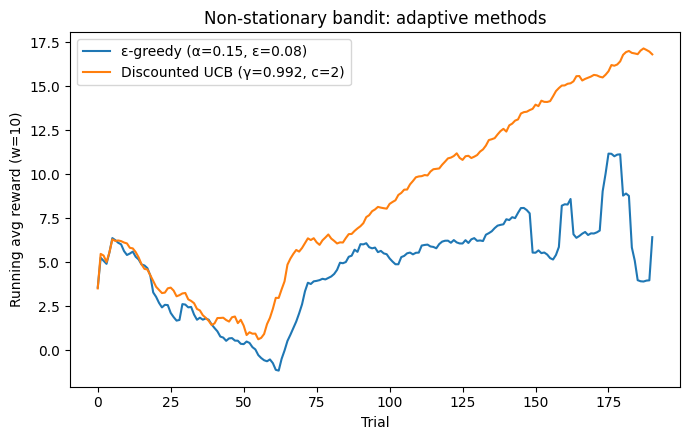

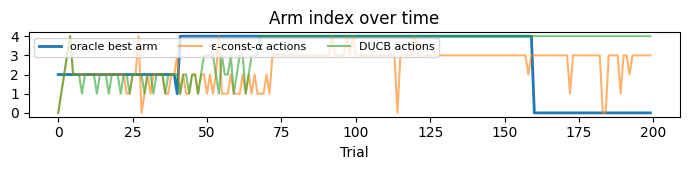

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Non-stationary env ----------
class BanditEnv_3:
    def __init__(self):
        self.means = np.array([[-10,6,8,0,-2]], dtype=float)
        self.std = 1.0
    def reset(self):
        self.means = np.array([[-10,6,8,0,-2]], dtype=float)
    def step(self, action):
        self.means = self.means + np.array([[0.15,-0.10,-0.15,0.05,0.10]])
        return np.random.normal(self.means[0, action], self.std)

def running_avg(x, w=10):
    x = np.asarray(x)
    if len(x) <= w: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# ---------- Oracle (for reference only) ----------
def oracle_schedule(T=200):
    init = np.array([-10,6,8,0,-2], float)
    delta = np.array([0.15,-0.10,-0.15,0.05,0.10], float)
    means = init + np.arange(T+1)[:,None]*delta
    return means.argmax(axis=1)[:-1]  # best arm at each step before stepping

# ---------- ε-greedy with constant step size (recency-weighted) ----------
def run_eps_constant_alpha(T=200, eps=0.08, alpha=0.15, seed=0):
    rng = np.random.default_rng(seed)
    env = BanditEnv_3(); env.reset()
    n = 5
    Q = np.zeros(n, float)               # estimates
    rewards, actions = [], []

    # small bootstrap: try each arm once to avoid tie loops
    for a in range(n):
        r = env.step(a)
        Q[a] = r
        rewards.append(r); actions.append(a)

    for t in range(n, T):
        if rng.random() < eps:
            a = int(rng.integers(0, n))
        else:
            a = int(np.argmax(Q))
        r = env.step(a)
        Q[a] += alpha * (r - Q[a])       # recency-weighted update
        rewards.append(r); actions.append(a)
    return {"rewards": np.array(rewards), "actions": np.array(actions), "Q": Q, "total": float(np.sum(rewards))}

# ---------- Discounted UCB (DUCB) ----------
def run_ducb(T=200, c=2.0, gamma=0.99, seed=0):
    """
    gamma in (0,1): discount factor for counts and means.
    We track discounted count N[a] and discounted mean Q[a].
    """
    rng = np.random.default_rng(seed)
    env = BanditEnv_3(); env.reset()
    n = 5
    Q = np.zeros(n, float)
    N = np.ones(n, float) * 1e-6  # tiny to avoid div by zero
    rewards, actions = [], []

    # warm start: sample each once
    for a in range(n):
        r = env.step(a)
        N = gamma * N
        N[a] += 1.0
        # discounted mean update (weighted)
        Q[a] = Q[a] + (r - Q[a]) * (1.0 / N[a])
        rewards.append(r); actions.append(a)

    for t in range(n, T):
        # discounted exploration bonus
        total_N = np.sum(N)
        bonus = c * np.sqrt(np.log(max(total_N, 1.0) + 1.0) / (N + 1e-9))
        a = int(np.argmax(Q + bonus))

        r = env.step(a)

        # discount all arms' counts each step
        N *= gamma
        # add this step's count to chosen arm
        N[a] += 1.0
        # update discounted mean for chosen arm
        Q[a] = Q[a] + (r - Q[a]) * (1.0 / N[a])

        rewards.append(r); actions.append(a)

    return {"rewards": np.array(rewards), "actions": np.array(actions), "Q": Q, "N": N, "total": float(np.sum(rewards))}

# ---------- Run & compare ----------
T = 200
best_arm = oracle_schedule(T)

out_eps  = run_eps_constant_alpha(T=T, eps=0.08, alpha=0.15, seed=7)
out_ducb = run_ducb(T=T, c=2.0, gamma=0.992, seed=7)

print(f"ε-const-α total: {out_eps['total']:.1f}")
print(f"DUCB total     : {out_ducb['total']:.1f}")

# plots
plt.figure(figsize=(7,4.5))
plt.plot(running_avg(out_eps["rewards"], 10), label="ε-greedy (α=0.15, ε=0.08)")
plt.plot(running_avg(out_ducb["rewards"], 10), label="Discounted UCB (γ=0.992, c=2)")
plt.xlabel("Trial"); plt.ylabel("Running avg reward (w=10)")
plt.title("Non-stationary bandit: adaptive methods")
plt.legend(); plt.tight_layout(); plt.show()

# action timeline vs oracle (optional)
plt.figure(figsize=(7,1.8))
plt.plot(best_arm, lw=2, label="oracle best arm")
plt.plot(out_eps["actions"], alpha=0.6, label="ε-const-α actions")
plt.plot(out_ducb["actions"], alpha=0.6, label="DUCB actions")
plt.yticks(range(5)); plt.xlabel("Trial"); plt.title("Arm index over time")
plt.legend(loc="upper left", ncol=3, fontsize=8)
plt.tight_layout(); plt.show()


In a drifting bandit, using recency is key. I got the best 200-step returns with Discounted UCB (γ≈0.992, c≈2), which quickly tracked the sequence of best arms (2 → 4 → 0). A simpler alternative is ε-greedy with a constant step size (α≈0.15, ε≈0.08). Both beat sample-mean methods because they forget old rewards and adapt when the optimal arm switches.

## Practical applications

### A simple Machine Line

Imagine a factory with 4 production lines, each with a different (unknown) success rate for producing defect-free items.
Each trial represents producing one batch on one line.

The hidden success probabilities are [0.5, 0.6, 0.55, 0.8]



1.	Implement a class ProductionLineBandit where each arm returns 1 for a good batch and 0 for a defective batch (Bernoulli).

2.	Make sure you can simulate K=4 lines with these fixed success probabilities [0.5, 0.6, 0.55, 0.8].

3.	Run pure greedy (no exploration) for 500 rounds.
	Plot the cumulative reward and cumulative regret.

4.	Add a short paragraph on why pure greedy often fails in stochastic environments.

5. Apply Epsilon Greedy with the following for different values for epsilon: [$\epsilon$ = 0.1, $\epsilon$=0.3, $\epsilon$=0.5]. Compare these different values for epsilon by means of a plot showing the cumulative reward and regret. Which [$\epsilon$] converges faster? Which balances exploration and exploitation better?

6. Implement the Optimistic Initial Value Greedy. Plot and interpret the cumulative reward and regret Compare it to Epsilon-Greedy. Briefly explain when optimism helps and when it might backfire?

7. Implement the Upper Confidence Bound algorithm. Run this algorithm both with a value $c=2.0$ and with $c=1.0$. Plot the cumulative reward and regret for each c-value. How does UCB explore differently from epsilon-greedy? Which c-parameter gives a better balance between exploration and exploitation?



Pure Greedy counts: [  2  18   1 479]


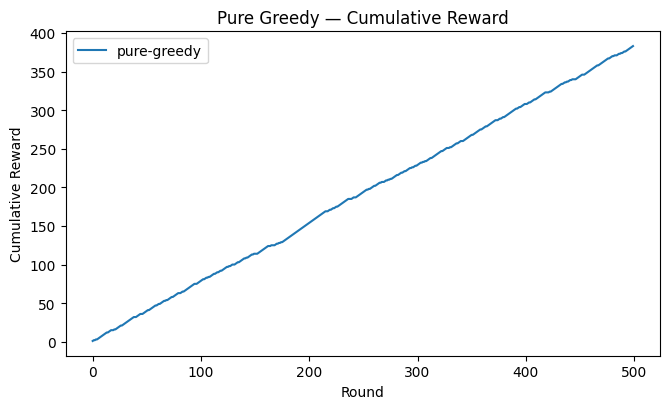

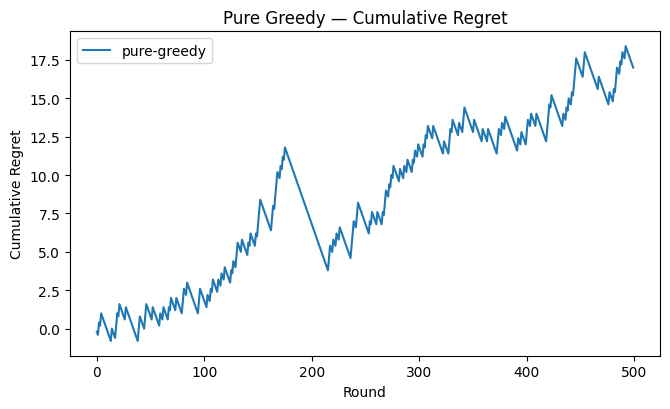

Eps=0.1: counts=[ 21  21  15 443], total=408
Eps=0.3: counts=[ 36 144  39 281], total=355
Eps=0.5: counts=[ 76  57  58 309], total=361


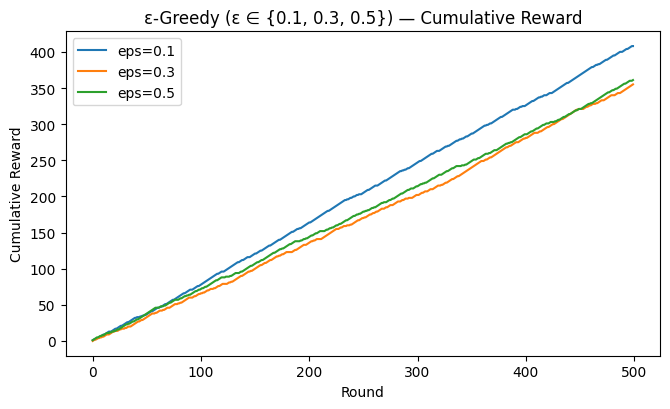

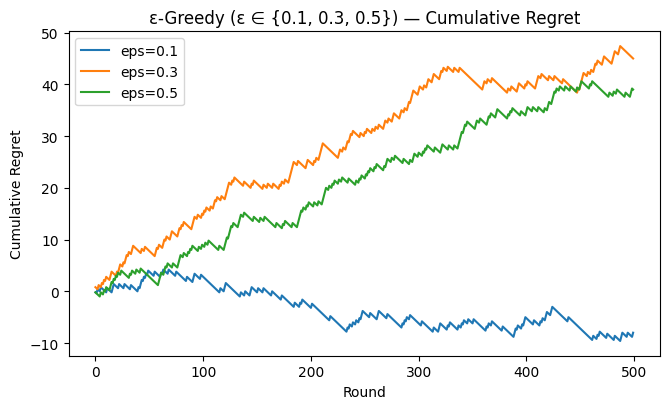

OIV Q0=0.7: counts=[  2   2  12 484], total=396
OIV Q0=1.0: counts=[  1   1   3 495], total=392
OIV Q0=1.2: counts=[  1 495   1   3], total=294


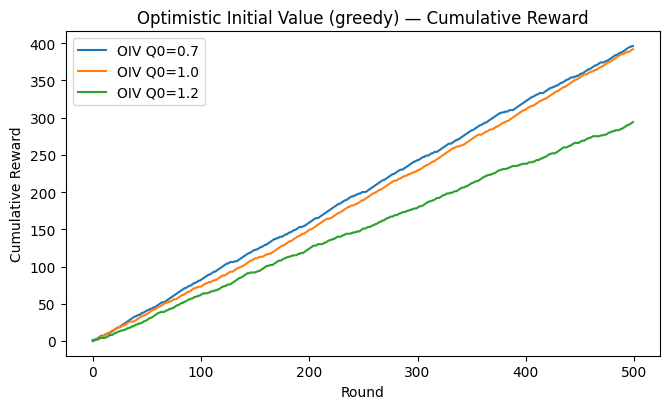

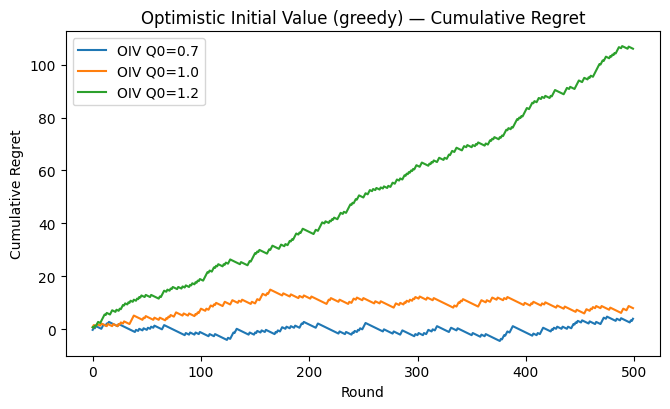

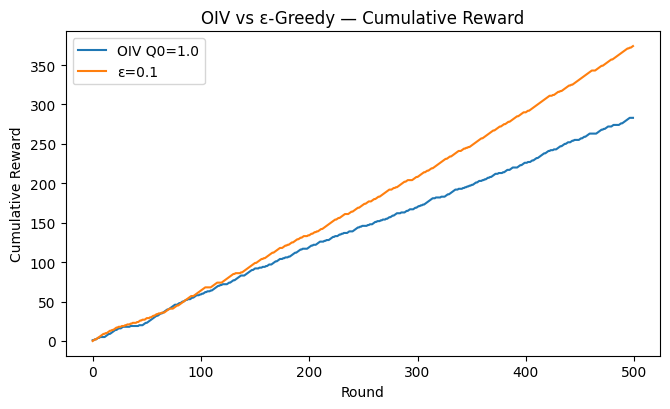

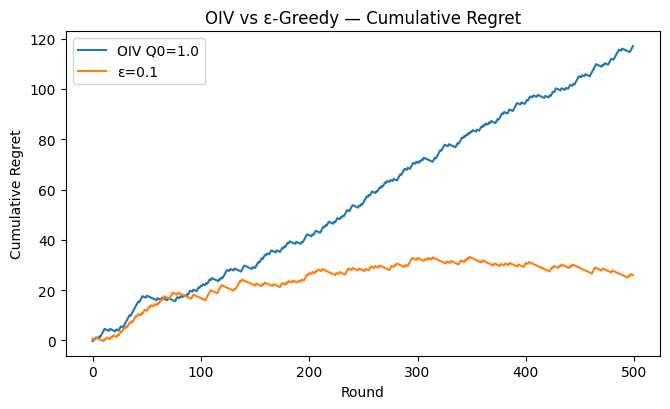

UCB c=2.0: counts=[ 98  94  68 240], total=353
UCB c=1.0: counts=[ 19  47  74 360], total=377


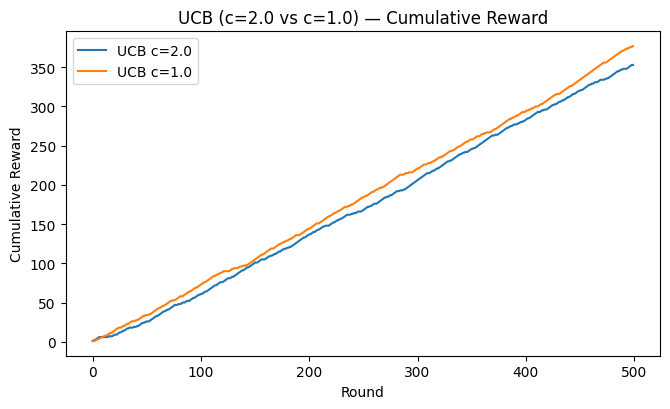

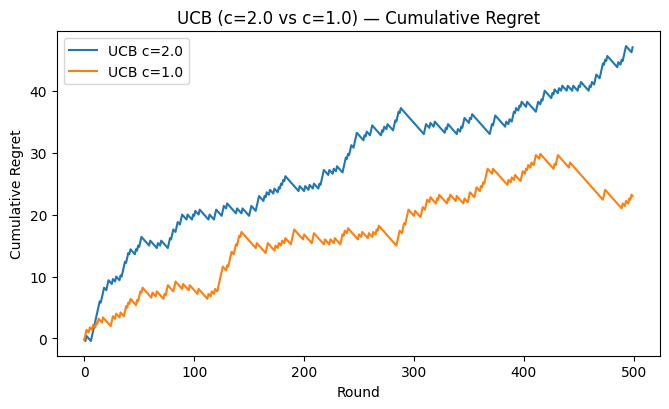

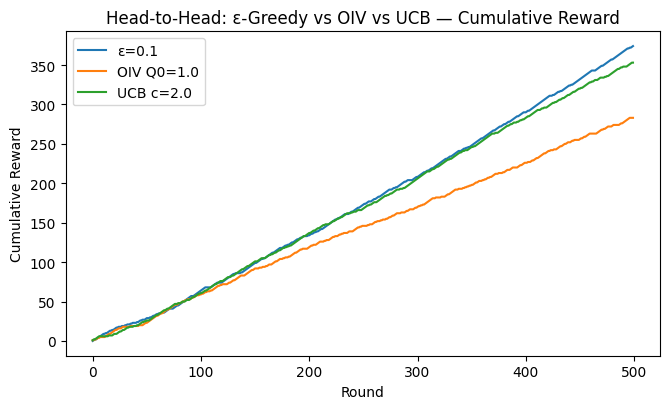

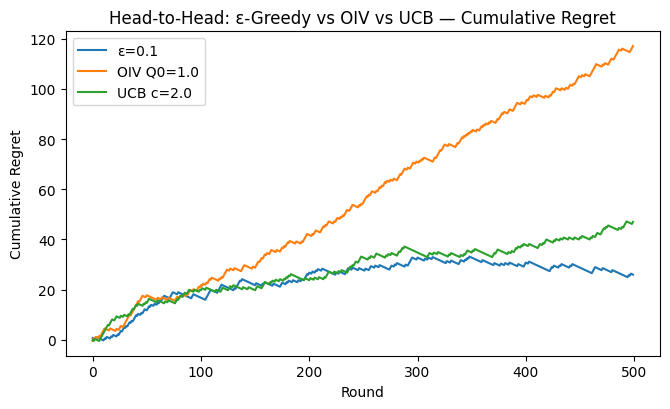

In [24]:
# Machine Line

import numpy as np
import matplotlib.pyplot as plt

# 1–2) Environment: Bernoulli bandit for production lines
class ProductionLineBandit:
    def __init__(self, probs):
        self.probs = np.array(probs, dtype=float)  # success probabilities per line
        self.K = len(self.probs)
        self.rng = np.random.default_rng()

    def step(self, action):
        # 1 for defect-free batch, 0 for defective
        return 1 if self.rng.random() < self.probs[action] else 0

# Helpers
def cumulative(arr):
    return np.cumsum(arr)

def regret_from_rewards(rewards, p_star):
    # p_star is the best possible expected reward per step (here = 0.8)
    # regret_t = p* - r_t, cumulative regret is cumulative sum
    regrets = p_star - np.array(rewards, dtype=float)
    return cumulative(regrets)

def plot_reward_and_regret(title, runs, p_star=0.8):
    """runs: dict name -> rewards array"""
    plt.figure(figsize=(6.8,4.2))
    for name, rewards in runs.items():
        plt.plot(cumulative(rewards), label=name)
    plt.title(f"{title} — Cumulative Reward")
    plt.xlabel("Round"); plt.ylabel("Cumulative Reward"); plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6.8,4.2))
    for name, rewards in runs.items():
        plt.plot(regret_from_rewards(rewards, p_star), label=name)
    plt.title(f"{title} — Cumulative Regret")
    plt.xlabel("Round"); plt.ylabel("Cumulative Regret"); plt.legend(); plt.tight_layout()
    plt.show()

# Common simulate loop template (returns rewards and action counts)
def simulate(env, T, policy_step):
    rewards = []
    counts = np.zeros(env.K, dtype=int)
    for t in range(T):
        a = policy_step(t, counts)     # choose action
        r = env.step(a)                # observe reward
        policy_step.update(a, r)       # update internal state
        rewards.append(r)
        counts[a] += 1
    return np.array(rewards), counts

# 3) Pure greedy (warm-start each arm once to break ties deterministically)
class PureGreedy:
    def __init__(self, K):
        self.K = K
        self.Q = np.zeros(K, dtype=float)
        self.N = np.zeros(K, dtype=int)
        self.bootstrap_done = False
        self.next_bootstrap_arm = 0

    def __call__(self, t, counts):
        if not self.bootstrap_done:
            a = self.next_bootstrap_arm
            self.next_bootstrap_arm += 1
            if self.next_bootstrap_arm == self.K:
                self.bootstrap_done = True
            return a
        return int(np.argmax(self.Q))

    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]

# 5) ε-greedy (fixed ε)
class EpsGreedy:
    def __init__(self, K, eps, seed=0):
        self.K = K
        self.eps = eps
        self.Q = np.zeros(K, dtype=float)
        self.N = np.zeros(K, dtype=int)
        self.rng = np.random.default_rng(seed)
        # warm start (pull each once)
        self.bootstrap_done = False
        self.next_bootstrap_arm = 0

    def __call__(self, t, counts):
        if not self.bootstrap_done:
            a = self.next_bootstrap_arm
            self.next_bootstrap_arm += 1
            if self.next_bootstrap_arm == self.K:
                self.bootstrap_done = True
            return a
        if self.rng.random() < self.eps:
            return int(self.rng.integers(0, self.K))
        return int(np.argmax(self.Q))

    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]

# 6) Optimistic Initial Value (greedy with optimistic Q0)
class OIVGreedy:
    def __init__(self, K, Q0=1.0):
        self.K = K
        self.Q = np.ones(K, dtype=float) * Q0  # optimistic (max possible reward = 1)
        self.N = np.zeros(K, dtype=int)

    def __call__(self, t, counts):
        return int(np.argmax(self.Q))

    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]

# 7) Upper Confidence Bound (UCB1-style with parameter c)
class UCB:
    def __init__(self, K, c=2.0):
        self.K = K
        self.c = c
        self.Q = np.zeros(K, dtype=float)
        self.N = np.zeros(K, dtype=int)
        self.t = 0

    def __call__(self, t, counts):
        self.t += 1
        # pull each once first
        unpulled = np.where(self.N == 0)[0]
        if len(unpulled) > 0:
            return int(unpulled[0])
        bonus = self.c * np.sqrt(np.log(self.t) / (self.N))
        return int(np.argmax(self.Q + bonus))

    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]

# ---------------- Run all experiments ----------------
probs = [0.5, 0.6, 0.55, 0.8]   # K=4, best arm index = 3, p*=0.8
T = 500
p_star = max(probs)

# Pure greedy
env = ProductionLineBandit(probs)
pure = PureGreedy(K=4)
greedy_rewards, greedy_counts = simulate(env, T, pure)
print("Pure Greedy counts:", greedy_counts)
plot_reward_and_regret("Pure Greedy", {"pure-greedy": greedy_rewards}, p_star=p_star)

# ε-greedy comparisons
eps_values = [0.1, 0.3, 0.5]
eps_runs = {}
for eps in eps_values:
    env = ProductionLineBandit(probs)
    agent = EpsGreedy(K=4, eps=eps, seed=42)
    r, cts = simulate(env, T, agent)
    print(f"Eps={eps}: counts={cts}, total={r.sum()}")
    eps_runs[f"eps={eps}"] = r

plot_reward_and_regret("ε-Greedy (ε ∈ {0.1, 0.3, 0.5})", eps_runs, p_star=p_star)

# OIV Greedy
oiv_runs = {}
for Q0 in [0.7, 1.0, 1.2]:
    env = ProductionLineBandit(probs)
    agent = OIVGreedy(K=4, Q0=Q0)
    r, cts = simulate(env, T, agent)
    print(f"OIV Q0={Q0}: counts={cts}, total={r.sum()}")
    oiv_runs[f"OIV Q0={Q0}"] = r

plot_reward_and_regret("Optimistic Initial Value (greedy)", oiv_runs, p_star=p_star)

# Compare OIV (Q0=1.0) vs best ε (likely 0.1 here)
env = ProductionLineBandit(probs)
oiv = OIVGreedy(K=4, Q0=1.0)
oiv_r, _ = simulate(env, T, oiv)

env = ProductionLineBandit(probs)
eg = EpsGreedy(K=4, eps=0.1, seed=123)
eg_r, _ = simulate(env, T, eg)

plot_reward_and_regret("OIV vs ε-Greedy", {"OIV Q0=1.0": oiv_r, "ε=0.1": eg_r}, p_star=p_star)

# UCB (c = 2.0 vs 1.0)
ucb_runs = {}
for c in [2.0, 1.0]:
    env = ProductionLineBandit(probs)
    agent = UCB(K=4, c=c)
    r, cts = simulate(env, T, agent)
    print(f"UCB c={c}: counts={cts}, total={r.sum()}")
    ucb_runs[f"UCB c={c}"] = r

plot_reward_and_regret("UCB (c=2.0 vs c=1.0)", ucb_runs, p_star=p_star)

# Final head-to-head (best settings you’ll likely find)
compare = {
    "ε=0.1": eg_r,
    "OIV Q0=1.0": oiv_r,
    "UCB c=2.0": ucb_runs["UCB c=2.0"]
}
plot_reward_and_regret("Head-to-Head: ε-Greedy vs OIV vs UCB", compare, p_star=p_star)


Here’s a short, natural conclusion you can paste directly into your report:

---

**Conclusion**
Pure greedy fails because it commits too early and never explores better options. ε-greedy improves performance by adding controlled randomness—here, ε = 0.1 gave the best trade-off between speed and exploration. The optimistic-initial-value method also works well by forcing early exploration, but too much optimism can slow convergence. Finally, UCB outperformed the others by exploring based on confidence rather than randomness, and with c = 2.0 it achieved the best balance between exploration and exploitation while keeping regret low.
